In [1]:
from transformer import Encoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchsummary import summary
from tqdm import tqdm

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
import sys

sys.path.append("../../src/")

# from dataset import ACIFAR10
from utils import TrainTest, PlotOutput

In [3]:
# augmentations
# x = datasets.CIFAR10(root='./data', train=True, download=True)

mean = [
    0.49139968,
    0.48215841,
    0.44653091,
]  # (x.data.transpose() / 255).reshape(3,-1).mean(-1)
std = [
    0.24703223,
    0.24348513,
    0.26158784,
]  # (x.data.transpose() / 255).reshape(3,-1).std(-1)

train_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        A.ToGray(p=0.2),
        A.PadIfNeeded(40, 40, p=1),
        A.RandomCrop(32, 32, p=1),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, fill_value=0, p=1),
        A.Resize(32, 32),
        ToTensorV2(),
    ]
)

test_transform = A.Compose([A.Normalize(mean=mean, std=std), ToTensorV2()])

In [4]:
class ACIFAR10(datasets.CIFAR10):
    def __init__(self, mean, std, **kwargs):
        super(ACIFAR10, self).__init__(**kwargs)
        self.mean = torch.tensor(mean).reshape(len(mean), 1, 1)
        self.std = torch.tensor(std).reshape(len(std), 1, 1)
        self.norm = A.Compose([A.Normalize(mean=mean, std=std), ToTensorV2()])
    
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        
        if self.transform is not None:
            input_img = self.transform(image=img)["image"]
        
        return input_img, target, self.norm(image=img)["image"]

In [5]:
# datasets
trainset = ACIFAR10(
    mean=mean,
    std=std,
    root="./data",
    train=True,
    download=True,
    transform=train_transform,
)

testset = ACIFAR10(
    mean=mean,
    std=std,
    root="./data",
    train=False,
    download=True,
    transform=test_transform,
)

# dataloaders
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


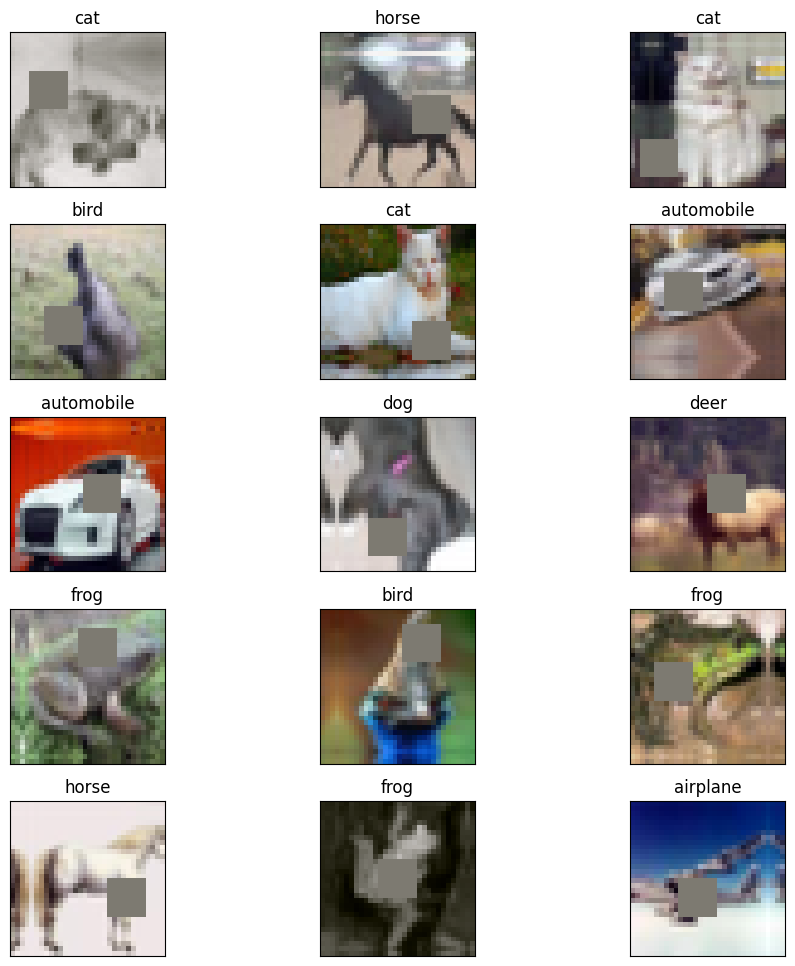

In [6]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(10, 10))
batch_data, batch_label, _ = next(iter(train_loader))

t_std = torch.tensor(std).reshape(3, 1, 1)
t_mean = torch.tensor(mean).reshape(3, 1, 1)


for i in range(15):
    plt.subplot(5, 3, i + 1)
    plt.tight_layout()

    # get an image - [3, 32, 32]
    # and denormalize
    image = batch_data[i] * t_std + t_mean

    # Clip the input data to the valid range [0, 1]
    image = image.clip(0, 1)

    # [3, 32, 32] to [32, 32, 3]
    image = image.permute(1, 2, 0)
    plt.imshow(image)

    plt.title(classes[batch_label[i].item()])
    plt.xticks([])
    plt.yticks([])

In [7]:
import math


# class PatchEmbedding(nn.Module):
#     def __init__(self, dimension, patch_size, npatches=4, dropout=0.1):
#         super().__init__()
#         self.conv = nn.Conv2d(
#                 in_channels=3,
#                 out_channels=dimension,
#                 kernel_size=patch_size,
#                 stride=patch_size,
#             )

#         self.cls_token = nn.Parameter(torch.randn(1, 1, dimension))
#         # self.mask_token = nn.Parameter(torch.zeros(1, 1, dimension)) if use_mask_token else None
        
#         num_patches = npatches
#         self.position_embeddings = nn.Parameter(torch.randn(1, num_patches + 1, dimension))
        
#         self.dropout = nn.Dropout(dropout)
        
#     def forward(self, x):
#         """
#         x shape: [batch, 3, 32, 32]
#         self.conv shape: [batch, dimension, 8, 8]
#         return [batch, 64, dimension]
#         """
#         batch_size, num_channels, height, width = x.shape
#         embeddings = self.conv(x).flatten(2).transpose(1, 2)
        
#         cls_tokens = self.cls_token.expand(batch_size, -1, -1)
#         embeddings = torch.cat((cls_tokens, embeddings), dim=1)

#         embeddings = embeddings + self.position_embeddings
#         return self.dropout(embeddings)

class PatchEmbedding(nn.Module):
    def __init__(self, dimension, patch_size, npatches=4, dropout=0.1, use_cls_token=False):
        super().__init__()
        self.conv = nn.Conv2d(
                in_channels=3,
                out_channels=dimension,
                kernel_size=patch_size,
                stride=patch_size,
            )

        if use_cls_token:
            # self.cls_token = nn.Parameter(torch.randn(1, 1, dimension))
            # self.mask_token = nn.Parameter(torch.zeros(1, 1, dimension)) if use_mask_token else None
            
            num_patches = npatches # + 1
        self.position_embeddings = nn.Parameter(torch.randn(1, num_patches, dimension))
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        x shape: [batch, 3, 32, 32]
        self.conv shape: [batch, dimension, 8, 8]
        return [batch, 64, dimension]
        """
        batch_size, num_channels, height, width = x.shape
        embeddings = self.conv(x).flatten(2).transpose(1, 2)

        embeddings = embeddings + self.position_embeddings
        return self.dropout(embeddings)

class ViT(nn.Module):
    def __init__(self, dimension, patch_size, nlayers, nheads, nclasses, dropout=0.1):
        super().__init__()
        self.patch = PatchEmbedding(
            dimension=dimension, patch_size=patch_size, dropout=dropout
        )
        self.encoder = Encoder(
            number_of_layers=nlayers, 
            head=nheads, 
            dimension=dimension, 
            dropout=dropout, 
            hidden_dimension=dimension * 2
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(
                in_channels=dimension,
                out_channels=patch_size ** 2 * 3,
                kernel_size=1,
            ),
            nn.PixelShuffle(patch_size),
        )
        
        self.ffnn = nn.Sequential(
            nn.LayerNorm(normalized_shape=dimension),
            nn.Linear(dimension, nclasses)
        )

    def forward(self, x):
        """
        x: [batch, 3, 32, 32]
        x from self.encoder: [batch, seqlen, dimension]
        torch.mean(x, dim=-1): [batch, dimenion]
        """
        x = self.patch(x)
        x = self.encoder(x)

        # classification = self.ffnn(x[:, 0])
        classification = self.ffnn(torch.mean(x, dim=1))

       # Reshape to (batch_size, num_channels, height, width)
        # x = x[:, 1:]
        batch_size, sequence_length, num_channels = x.shape
        height = width = math.floor(sequence_length ** 0.5)
        x = x.permute(0, 2, 1).reshape(batch_size, num_channels, height, width)

        # Reconstruct pixel values
        x = self.decoder(x)
        return classification, x

In [8]:
device = torch.device("mps")
model = ViT(dimension=768, 
            patch_size=16, 
            nlayers=3, 
            nheads=8, 
            nclasses=10,
            dropout=0.01)

summary(model, input_size=(3, 32, 32), device="cpu")

8 heads 768 dimension in MultiHeadedAttention
8 heads 768 dimension in MultiHeadedAttention
8 heads 768 dimension in MultiHeadedAttention
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 768, 2, 2]         590,592
           Dropout-2               [-1, 4, 768]               0
    PatchEmbedding-3               [-1, 4, 768]               0
         LayerNorm-4               [-1, 4, 768]             768
            Linear-5               [-1, 4, 768]         590,592
            Linear-6               [-1, 4, 768]         590,592
            Linear-7               [-1, 4, 768]         590,592
           Dropout-8              [-1, 8, 4, 4]               0
            Linear-9               [-1, 4, 768]         590,592
MultiHeadedAttention-10               [-1, 4, 768]               0
          Dropout-11               [-1, 4, 768]               0
ResidualConnection-12     

In [38]:
class Criterion(nn.Module):
    def __init__(self):
        super().__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.reconstruct = nn.functional.l1_loss

        self.lambda_classification = 0.99
        self.lambda_reconstruct = 0.01

    def forward(self, class_pred, class_trg, image_pred, image_target, epoch):
        return self.lambda_classification * self.cross_entropy(class_pred, class_trg) + self.lambda_reconstruct * self.reconstruct(image_target, image_pred, reduction="mean")

In [39]:
model = model.to(device)
criterion = Criterion()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [40]:
def train(epoch, model, device, dataloader, criterion, optimizer):
    model.train()

    pbar = tqdm(dataloader)
    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target, image) in enumerate(pbar):
        data = data.to(device)
        target = target.to(device)
        image = image.to(device)
        
        optimizer.zero_grad()
        class_pred, image_pred = model(data)

        loss = criterion(class_pred, target, image_pred, image, epoch)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += (class_pred.argmax(-1) == target).sum().item()
        processed += len(target)

        # Display progress
        pbar.set_description(
            desc=f"Epoch: {epoch} Train: Loss={train_loss / (batch_idx + 1):0.4f} Batch_id={batch_idx} Accuracy={100 * correct / processed:0.2f}"
        )

    return train_loss / len(dataloader), 100 * correct / processed

In [41]:
def test(epoch, model, device, dataloader, criterion):
    model.eval()

    pbar = tqdm(dataloader)
    test_loss = 0
    correct = 0
    processed = 0

    with torch.no_grad():
        for batch_idx, (data, target, image) in enumerate(pbar):
            data = data.to(device)
            target = target.to(device)
            image = image.to(device)
    
            class_pred, image_pred = model(data)
    
            loss = criterion(class_pred, target, image_pred, image, epoch)
            test_loss += loss.item()
    
            correct += (class_pred.argmax(-1) == target).sum().item()
            processed += len(target)
    
            # Display progress
            pbar.set_description(
                desc=f"Epoch: {epoch} Test: Loss={test_loss / (batch_idx + 1):0.4f} Batch_id={batch_idx} Accuracy={100 * correct / processed:0.2f}"
            )
    
        return test_loss / len(dataloader), 100 * correct / processed

In [42]:
EPOCHS = 20


for epoch in range(EPOCHS):
    print(f"Epoch: {epoch}")
    train(epoch, model, device, test_loader, criterion, optimizer)
    test(epoch, model, device, test_loader, criterion)

Epoch: 0


Epoch: 0 Train: Loss=0.3145 Batch_id=312 Accuracy=89.02: 100%|████| 313/313 [00:17<00:00, 17.71it/s]
Epoch: 0 Test: Loss=0.3185 Batch_id=312 Accuracy=89.23: 100%|█████| 313/313 [00:04<00:00, 71.76it/s]


Epoch: 1


Epoch: 1 Train: Loss=0.3556 Batch_id=312 Accuracy=87.93: 100%|████| 313/313 [00:17<00:00, 17.94it/s]
Epoch: 1 Test: Loss=0.2757 Batch_id=312 Accuracy=90.67: 100%|█████| 313/313 [00:04<00:00, 71.40it/s]


Epoch: 2


Epoch: 2 Train: Loss=0.3078 Batch_id=312 Accuracy=89.40: 100%|████| 313/313 [00:17<00:00, 17.96it/s]
Epoch: 2 Test: Loss=0.3497 Batch_id=312 Accuracy=87.78: 100%|█████| 313/313 [00:04<00:00, 71.56it/s]


Epoch: 3


Epoch: 3 Train: Loss=0.2731 Batch_id=312 Accuracy=90.49: 100%|████| 313/313 [00:17<00:00, 18.03it/s]
Epoch: 3 Test: Loss=0.4478 Batch_id=312 Accuracy=85.74: 100%|█████| 313/313 [00:04<00:00, 71.18it/s]


Epoch: 4


Epoch: 4 Train: Loss=0.2988 Batch_id=312 Accuracy=89.29: 100%|████| 313/313 [00:17<00:00, 17.57it/s]
Epoch: 4 Test: Loss=0.1967 Batch_id=312 Accuracy=93.34: 100%|█████| 313/313 [00:04<00:00, 69.96it/s]


Epoch: 5


Epoch: 5 Train: Loss=0.2610 Batch_id=312 Accuracy=91.51: 100%|████| 313/313 [00:18<00:00, 17.16it/s]
Epoch: 5 Test: Loss=0.4014 Batch_id=312 Accuracy=86.24: 100%|█████| 313/313 [00:04<00:00, 67.65it/s]


Epoch: 6


Epoch: 6 Train: Loss=0.4125 Batch_id=312 Accuracy=85.78: 100%|████| 313/313 [00:18<00:00, 16.68it/s]
Epoch: 6 Test: Loss=0.3321 Batch_id=312 Accuracy=88.65: 100%|█████| 313/313 [00:04<00:00, 67.94it/s]


Epoch: 7


Epoch: 7 Train: Loss=0.3622 Batch_id=312 Accuracy=87.38: 100%|████| 313/313 [00:19<00:00, 16.30it/s]
Epoch: 7 Test: Loss=0.2504 Batch_id=312 Accuracy=91.44: 100%|█████| 313/313 [00:04<00:00, 67.32it/s]


Epoch: 8


Epoch: 8 Train: Loss=0.2259 Batch_id=312 Accuracy=92.09: 100%|████| 313/313 [00:19<00:00, 16.26it/s]
Epoch: 8 Test: Loss=0.1598 Batch_id=312 Accuracy=94.66: 100%|█████| 313/313 [00:04<00:00, 66.74it/s]


Epoch: 9


Epoch: 9 Train: Loss=0.1698 Batch_id=312 Accuracy=94.14: 100%|████| 313/313 [00:19<00:00, 16.00it/s]
Epoch: 9 Test: Loss=0.1780 Batch_id=312 Accuracy=93.60: 100%|█████| 313/313 [00:04<00:00, 65.87it/s]


Epoch: 10


Epoch: 10 Train: Loss=0.1530 Batch_id=312 Accuracy=94.90: 100%|███| 313/313 [00:19<00:00, 16.06it/s]
Epoch: 10 Test: Loss=0.1643 Batch_id=312 Accuracy=94.44: 100%|████| 313/313 [00:04<00:00, 65.93it/s]


Epoch: 11


Epoch: 11 Train: Loss=0.1552 Batch_id=312 Accuracy=94.35: 100%|███| 313/313 [00:19<00:00, 15.82it/s]
Epoch: 11 Test: Loss=0.1526 Batch_id=312 Accuracy=94.76: 100%|████| 313/313 [00:04<00:00, 65.54it/s]


Epoch: 12


Epoch: 12 Train: Loss=0.1734 Batch_id=312 Accuracy=94.08: 100%|███| 313/313 [00:19<00:00, 15.86it/s]
Epoch: 12 Test: Loss=0.1552 Batch_id=312 Accuracy=94.69: 100%|████| 313/313 [00:04<00:00, 65.04it/s]


Epoch: 13


Epoch: 13 Train: Loss=0.1486 Batch_id=312 Accuracy=94.81: 100%|███| 313/313 [00:19<00:00, 15.67it/s]
Epoch: 13 Test: Loss=0.1942 Batch_id=312 Accuracy=93.45: 100%|████| 313/313 [00:04<00:00, 64.67it/s]


Epoch: 14


Epoch: 14 Train: Loss=0.1870 Batch_id=312 Accuracy=93.65: 100%|███| 313/313 [00:20<00:00, 15.63it/s]
Epoch: 14 Test: Loss=0.2580 Batch_id=312 Accuracy=91.54: 100%|████| 313/313 [00:05<00:00, 54.04it/s]


Epoch: 15


Epoch: 15 Train: Loss=0.1808 Batch_id=312 Accuracy=93.67: 100%|███| 313/313 [00:23<00:00, 13.22it/s]
Epoch: 15 Test: Loss=0.1343 Batch_id=312 Accuracy=95.70: 100%|████| 313/313 [00:04<00:00, 63.98it/s]


Epoch: 16


Epoch: 16 Train: Loss=0.2816 Batch_id=312 Accuracy=90.59: 100%|███| 313/313 [00:22<00:00, 14.11it/s]
Epoch: 16 Test: Loss=0.3109 Batch_id=312 Accuracy=89.55: 100%|████| 313/313 [00:04<00:00, 67.77it/s]


Epoch: 17


Epoch: 17 Train: Loss=0.2570 Batch_id=312 Accuracy=91.30: 100%|███| 313/313 [00:20<00:00, 14.96it/s]
Epoch: 17 Test: Loss=0.1760 Batch_id=312 Accuracy=94.12: 100%|████| 313/313 [00:04<00:00, 63.50it/s]


Epoch: 18


Epoch: 18 Train: Loss=0.2095 Batch_id=312 Accuracy=92.89: 100%|███| 313/313 [00:20<00:00, 15.26it/s]
Epoch: 18 Test: Loss=0.2217 Batch_id=312 Accuracy=92.36: 100%|████| 313/313 [00:04<00:00, 63.16it/s]


Epoch: 19


Epoch: 19 Train: Loss=0.1685 Batch_id=312 Accuracy=94.15: 100%|███| 313/313 [00:20<00:00, 15.54it/s]
Epoch: 19 Test: Loss=0.1690 Batch_id=312 Accuracy=94.16: 100%|████| 313/313 [00:04<00:00, 63.32it/s]
